# 2D Uplift model


<table><tr><td><img src='./images/Uplift-0.png'></td><td><img src='./images/Uplift-56.png'></td></tr></table>
(Left) Initial model setup. (Right) Model with steady state topography induced by basal traction condition (Stokes system's neumann condition).

#### This model utilises scaling to enable model input in dimensional units but model computation and output in scaled units.

In [1]:
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer
import os

model_end_step   = 3
output_path      = 'uplift/'
elType           = 'Q1/dQ0'
resolution       = (100,60)
    
# search and build, if required, an output path
if uw.rank()==0:
    try:
        if not os.path.exists("./"+output_path+"/"):
            os.makedirs("./"+output_path+'/')
    except:
        raise

In [2]:
# build reference units
u = uw.UnitRegistry
KL_meters   = 100e3 * u.meter
K_viscosity = 1e16  * u.pascal * u.second
K_density   = 3.3e3 * u.kilogram / (u.meter)**3

In [3]:
# compute dependent scaling units 
KM_kilograms = K_density * KL_meters**3
KT_seconds   = KM_kilograms / ( KL_meters * K_viscosity )
K_substance  = 1. * u.mole
Kt_degrees   = 1. * u.kelvin

uw.scaling_coefficients["[length]"]      = KL_meters.to_base_units()
uw.scaling_coefficients["[temperature]"] = Kt_degrees.to_base_units()
uw.scaling_coefficients["[time]"]        = KT_seconds.to_base_units()
uw.scaling_coefficients["[mass]"]        = KM_kilograms.to_base_units()

In [4]:
# all physical model parameters. Input as dimensional units, but scaled via `uw.nonDimensionalise()`
nd = uw.nonDimensionalize
gravity   = nd( 9.81 * u.meter / u.second**2)
density   = nd( 3300 * u.kilogram / u.meter**3)
viscosity = nd( 1e22 * u.Pa * u.sec)
bulk_visc = nd( 1e11 * u.Pa *u.sec)
Lx        = nd( 100e3 * u.meter)
Ly        = nd( 60e3 * u.meter)

# traction perturbation parameters
xp     = nd( 50e3 * u.meter)
width  = nd( 3e3  * u.meter)

# compute lithostatic load a prior
lithostaticPressure = 0.6*Ly*density*gravity

In [5]:
# build mesh and mesh variables
mesh = uw.mesh.FeMesh_Cartesian( elementType = elType, 
                                 elementRes  = resolution, 
                                 minCoord    = [0.,0.], 
                                 maxCoord    = [Lx,Ly] )

bottomWall = mesh.specialSets["Bottom_VertexSet"]
topWall    = mesh.specialSets["Top_VertexSet"]
iWalls     = mesh.specialSets["Left_VertexSet"] + mesh.specialSets["Right_VertexSet"]

velocityField = mesh.add_variable( nodeDofCount=mesh.dim )
tractionField = mesh.add_variable( nodeDofCount=2 )
pressureField = mesh.subMesh.add_variable( nodeDofCount=1 )

In [6]:
# Traction is force per unit area associated with a specific surface 
# ie, traction = stress * surface_unit_normal
for ii in bottomWall:
    coord = mesh.data[ii]
    tractionField.data[ii] = [0.0,lithostaticPressure*(1.+0.2*np.exp((-1/width*(coord[0]-xp)**2)))]

In [7]:
# visualise the bottom stress condition
if uw.nProcs() == 0:
    uw.matplotlib_inline()
    import matplotlib.pyplot as pyplot
    import matplotlib.pylab as pylab
    pyplot.ion()
    pylab.rcParams[ 'figure.figsize'] = 12, 6
    pyplot.title('Prescribed traction component normal to base wall')
    km_scaling  = uw.Dimensionalize(1,u.kilometer)
    MPa_scaling = uw.Dimensionalize(1,u.MPa)
    pyplot.xlabel('X coordinate - (x{}km)'.format(km_scaling.magnitude))
    pyplot.ylabel('Normal basal traction MPa - (x{:.3e}MPa)'.format(MPa_scaling.magnitude))
    
    xcoord = mesh.data[bottomWall.data][:,0]          # x coordinate
    stress = tractionField.data[bottomWall.data][:,1] # 2nd component of the traction along the bottom wall
    
    pyplot.plot( xcoord, stress, 'o', color = 'black', label='numerical') 
    pyplot.show()

In [8]:
# Initialise a swarm.
swarm = uw.swarm.Swarm( mesh=mesh, particleEscape=True )
advector= uw.systems.SwarmAdvector(velocityField, swarm, order=2)

# Add a data variable which will store an index to determine material.
materialVariable = swarm.add_variable( dataType="double", count=1 )

# Create a layout object that will populate the swarm across the whole domain.
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
# Populate.
swarm.populate_using_layout( layout=swarmLayout )

# material 0 - compressible Lambda=10, density = 0
# material 1 - incompressible Lambda=0, density = 1

materialVariable.data[:]=0
for index,coord in enumerate(swarm.particleCoordinates.data):
    if coord[1] < Ly*0.6:
        materialVariable.data[index]=1

# population control regulars particle creation and deletion
# important for inflow/outflow problems
population_control = uw.swarm.PopulationControl(swarm, 
                                                aggressive=True,splitThreshold=0.15, maxDeletions=2,maxSplits=10,
                                                particlesPerCell=20)

# build tracer swarm for fluid level - only 1 particle
mswarm = uw.swarm.Swarm( mesh=mesh, particleEscape=True )
msAdvector= uw.systems.SwarmAdvector(velocityField, mswarm, order=2)

# initial height at 'air' level
particleCoordinates = np.zeros((1,2))
particleCoordinates[:,0] = 0.5*Lx
particleCoordinates[:,1] = 0.6*Ly
ignore=mswarm.add_particles_with_coordinates(particleCoordinates)

# parallel safe way of finding the particles vertical coordinate.
fn_y = fn.coord()[1]
fn_y_minmax = fn.view.min_max(fn_y)


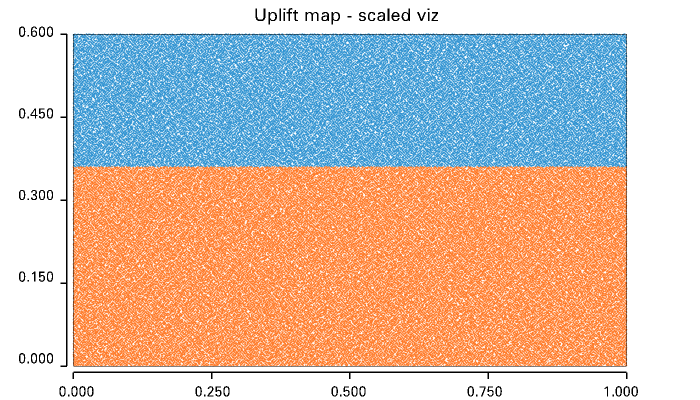

In [9]:
# Visualise the result
vdotv  = fn.math.dot(velocityField,velocityField)
velmag = fn.math.sqrt(vdotv)

cm_per_year = uw.Dimensionalize(1,u.centimeter/u.year)

fig1 = glucifer.Figure(title="Uplift map - scaled viz", figsize=(700,400), quality=2, rulers=True)
fig1.append( glucifer.objects.Points(mswarm, colourBar=False ) )
fig1.append( glucifer.objects.Points(swarm, materialVariable, fn_size=2.,colourBar = False  ) )
fig1.append( glucifer.objects.VectorArrows(mesh, cm_per_year.magnitude*0.1*velocityField) )

fig1.show()

In [10]:
# lambdaFn is created for pseudo compressible air layer
lambdaFn = uw.function.branching.map( fn_key=materialVariable, 
                                    mapping={ 0: 1/bulk_visc, 1: 0.0 } )

densityFn = uw.function.branching.map( fn_key=materialVariable, 
                                    mapping={ 0: 0.0, 1: density } )

forceFn = densityFn * (0.0,-gravity)

In [11]:
# assign degrees of freedom (on each node) to be considered Dirichlet.
stokesBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                             indexSetsPerDof = (iWalls, topWall) )

# assign neumann bcs
nbc      = uw.conditions.NeumannCondition( fn_flux=tractionField, variable = velocityField, 
                                             indexSetsPerDof = (None, bottomWall ) )

In [12]:
# setup solver
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = [stokesBC, nbc],
                               fn_viscosity  = viscosity, 
                               fn_bodyforce  = forceFn,
                               fn_one_on_lambda = lambdaFn )
solver = uw.systems.Solver( stokesPIC )

In [13]:
# fields / variable to save
fieldDict = {'velocity':velocityField, 'pressure':pressureField}
swarmDict = {'material':materialVariable}

In [14]:
# record output
outfile = open(output_path+'buildMount.txt', 'w+')
string = "steps, timestep, vrms, peak height"
if uw.rank()==0:
    print(string)
    outfile.write( string+"\n")

# initialise loop
fn_y_minmax.reset()
fn_y_minmax.evaluate(mswarm)
h1    = fn_y_minmax.max_global()
dt    = -1.
steps = 0

while steps<model_end_step:

    # Get solution
    solver.solve()

    # get time step first time around
    if dt < 0:
        dt = advector.get_max_dt()
    h0 = h1

    # Advect particles   
    advector.integrate(dt)  
    msAdvector.integrate(dt)

    # update peak heigh
    fn_y_minmax.reset()
    fn_y_minmax.evaluate(mswarm)
    h1 = fn_y_minmax.max_global()

    diffH = h1-h0
    string = "{}, {:.3e}, {:.3e}, {:.3e}".format(steps,
                                     uw.Dimensionalize(dt, u.milenia),
                                     uw.Dimensionalize(stokesPIC.velocity_rms(), u.cm/u.year),
                                     uw.Dimensionalize(diffH, u.metre) )
    if uw.rank() == 0:
        print(string)
        outfile.write(string+"\n")


    # population control
    population_control.repopulate()
    fig1.save(output_path+"Uplift-"+str(steps)+".png")

    steps += 1


outfile.close()

steps, timestep, vrms, peak height
0, 8.310e+01 millenium, 2.607e-01 centimeter / year, 3.015e+02 meter
1, 8.310e+01 millenium, 2.386e-01 centimeter / year, 2.719e+02 meter
2, 8.310e+01 millenium, 2.210e-01 centimeter / year, 2.426e+02 meter
3, 8.310e+01 millenium, 2.059e-01 centimeter / year, 2.238e+02 meter
4, 8.310e+01 millenium, 1.878e-01 centimeter / year, 2.041e+02 meter
5, 8.310e+01 millenium, 1.747e-01 centimeter / year, 1.836e+02 meter
6, 8.310e+01 millenium, 1.671e-01 centimeter / year, 1.730e+02 meter
7, 8.310e+01 millenium, 1.557e-01 centimeter / year, 1.511e+02 meter
8, 8.310e+01 millenium, 1.483e-01 centimeter / year, 1.407e+02 meter
9, 8.310e+01 millenium, 1.415e-01 centimeter / year, 1.297e+02 meter
10, 8.310e+01 millenium, 1.350e-01 centimeter / year, 1.197e+02 meter
11, 8.310e+01 millenium, 1.297e-01 centimeter / year, 1.088e+02 meter
12, 8.310e+01 millenium, 1.255e-01 centimeter / year, 1.000e+02 meter
13, 8.310e+01 millenium, 1.225e-01 centimeter / year, 9.473e+01 m


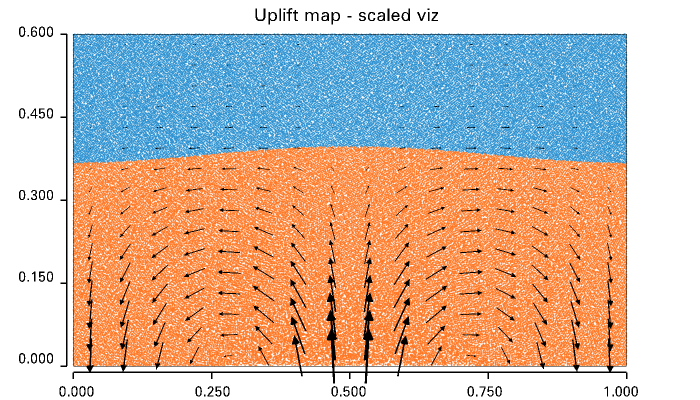

In [15]:
fig1.show()

In [16]:
# for testing purposes
dimensionalise=(diffH*uw.Dimensionalize(1,u.meter))
if np.fabs(dimensionalise.magnitude-245.140) > 0.05*245.140:
    raise RuntimeError("Height of passive tracer outside expected 5% tolerance")

RuntimeError: Height of passive tracer outside expected 5% tolerance